## Autoencoders

In [1]:
cd ../../src

/home/kuba/Projects/notebooks/examples-counterexamples/src


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import theano
import theano.tensor as T

from fetch_mnist import preprocessed_mnist
from neural_nets.autoencoder import Autoencoder 

In [3]:
X_train, X_test, y_train, y_test = preprocessed_mnist(random_state=0)

/opt/anaconda3/envs/nnets/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [4]:
def train_autoencoder(**kwargs):
  autoencoder = Autoencoder(**kwargs)

  %time autoencoder.fit(X_train)

  plt.plot(autoencoder.losses)
  plt.show()
  return autoencoder

def present_autoencoder_reconstruction(autoencoder):
  def plot_x(X1, X2, title, j=5):
    f, axes = plt.subplots(2, j, figsize=(20, 40 / j))
    f.suptitle(title)
    for k, x in zip(range(2), [X1, X2]):
      for i in range(j):
        ax = axes[k, i]
        img = x[i, :].reshape(28, 28)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()
  
  X_test_retrieved = autoencoder.retrieve(X_test)
  X_train_retrieved = autoencoder.retrieve(X_train)
  plot_x(X_train, X_train_retrieved, 'train', 10)
  plot_x(X_test, X_test_retrieved, 'test', 10)
 

In [5]:
shared_args = (dict(
  initialization_type='xavier',
  optimization_params={
    'method': 'momentum',
    'decay': 0.95},
  n_iter=1000,
  hidden_sizes = [250],
  batch_size = 1000,
  learning_rate=0.0001))

CPU times: user 2min 35s, sys: 952 ms, total: 2min 36s
Wall time: 1min 19s


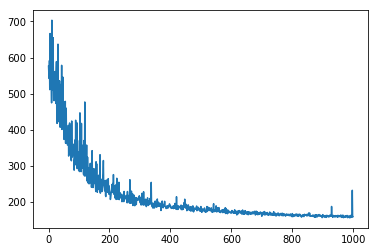

In [72]:
args_dict = (dict(
  lmbda=0.0005,
  l1_ratio=0.25))

args_dict.update(shared_args)

autoencoder = train_autoencoder(**args_dict)

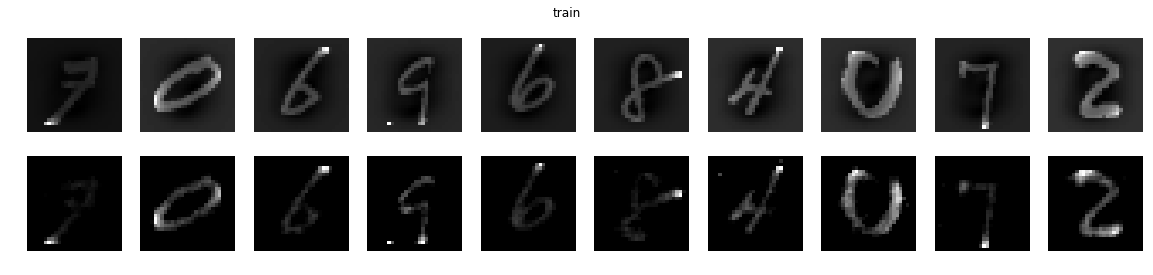

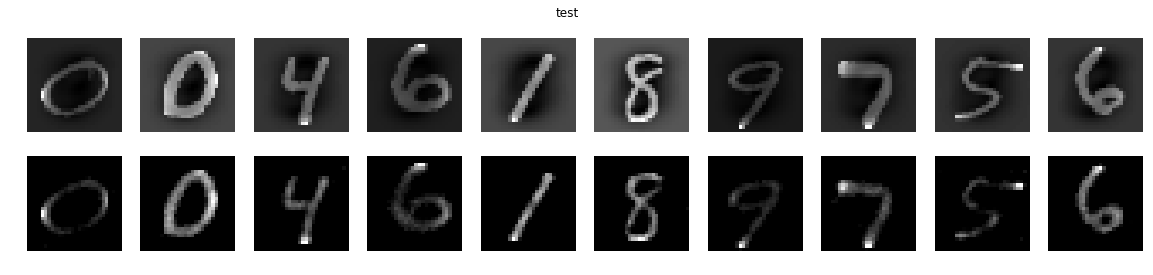

In [73]:
present_autoencoder_reconstruction(autoencoder)

CPU times: user 2min 22s, sys: 872 ms, total: 2min 23s
Wall time: 1min 12s


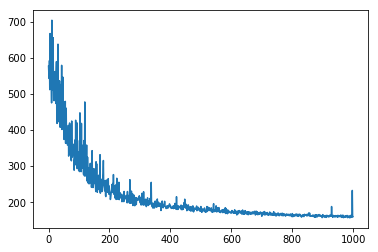

In [74]:
args_dict = (dict(
  lmbda=0.0005,
  l1_ratio=0.5))

args_dict.update(shared_args)

autoencoder = train_autoencoder(**args_dict)

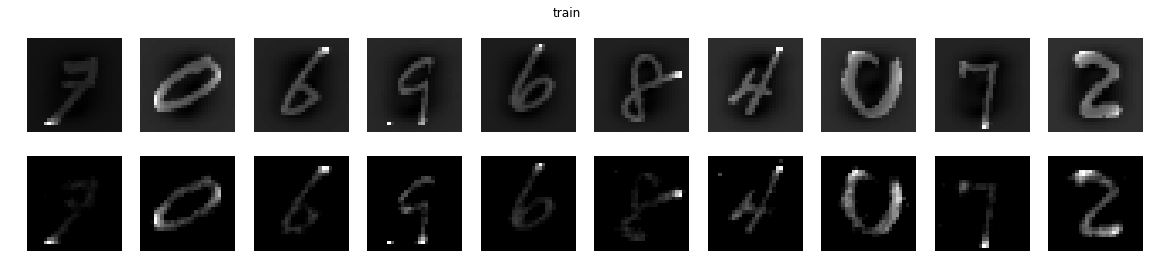

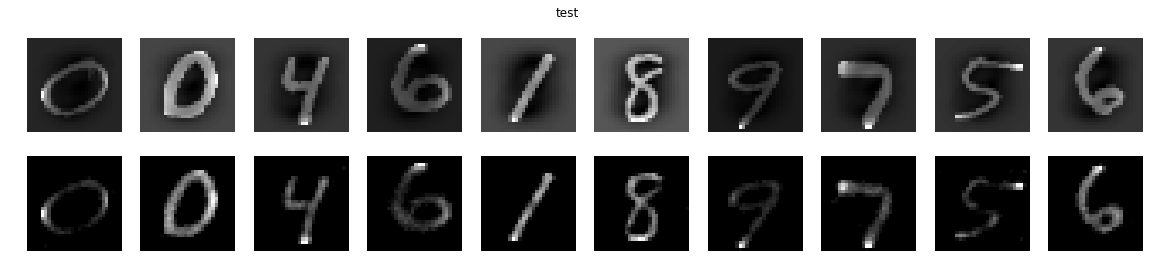

In [75]:
present_autoencoder_reconstruction(autoencoder)

CPU times: user 2min 12s, sys: 784 ms, total: 2min 13s
Wall time: 1min 10s


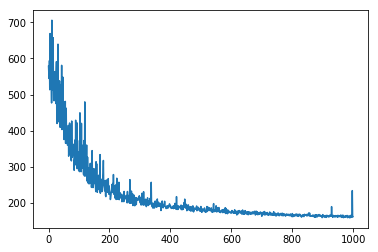

In [76]:
args_dict = (dict(
  lmbda=0.0005,
  l1_ratio=1))

args_dict.update(shared_args)

autoencoder = train_autoencoder(**args_dict)

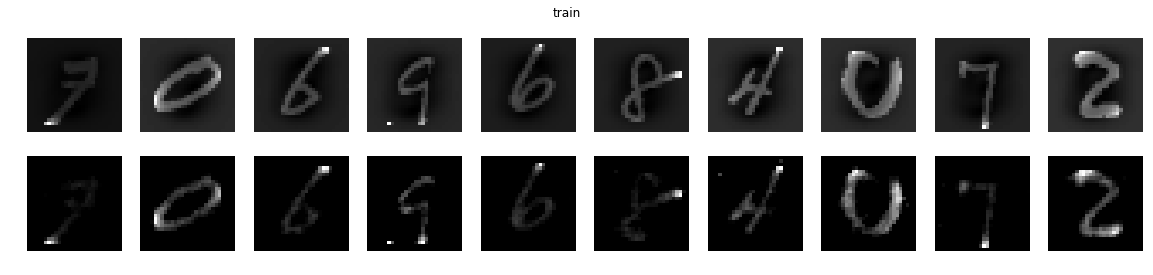

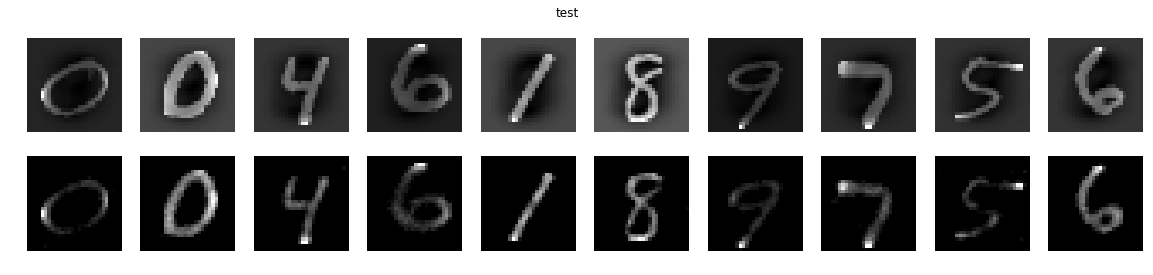

In [77]:
present_autoencoder_reconstruction(autoencoder)